In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
import os
import sys
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import torch
import torch.nn as nn
import numpy as np
import torchvision as tv
import torchvision.transforms as transforms
import torchvision.datasets as datasets
import pytorch_lightning as pl
import random
plt.rcParams['figure.figsize'] = [20, 10]
script_dir = os.path.dirname('__file__')
sys.path.append(os.path.join(script_dir, '..', 'src'))
from subset import Subset
import data_handler


c:\Users\lisap\miniconda3\envs\idp_env\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
seed = 45
random.seed(seed)
os.environ['PYTHONHASHSEED'] = str(seed)
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.cuda.manual_seed_all(seed)
torch.backends.cudnn.deterministic = True

In [3]:
# load dataset untransformed 
root = os.path.join("/", "space", "derma-data")
whole_dataset = datasets.ImageFolder(root, transforms.ToTensor())
train_data = Subset(whole_dataset, np.random.permutation(len(whole_dataset)-1))

# define trainloader
original_train_loader, val_loader = data_handler.setup_data_loaders(train_data, train_data, 16, 1.5, 0)
weighted_train_loader, val_loader = data_handler.setup_data_loaders(train_data, train_data, 16, 1.5, 1)
rel_weighted_train_loader, val_loader = data_handler.setup_data_loaders(train_data, train_data, 16, 1.5, 2)
spec_weighted_train_loader, val_loader = data_handler.setup_data_loaders(train_data, train_data, 16, 1.5, 3)

Use oversampling and weighted sampler
Use oversampling and weighted sampler
Use oversampling and weighted sampler


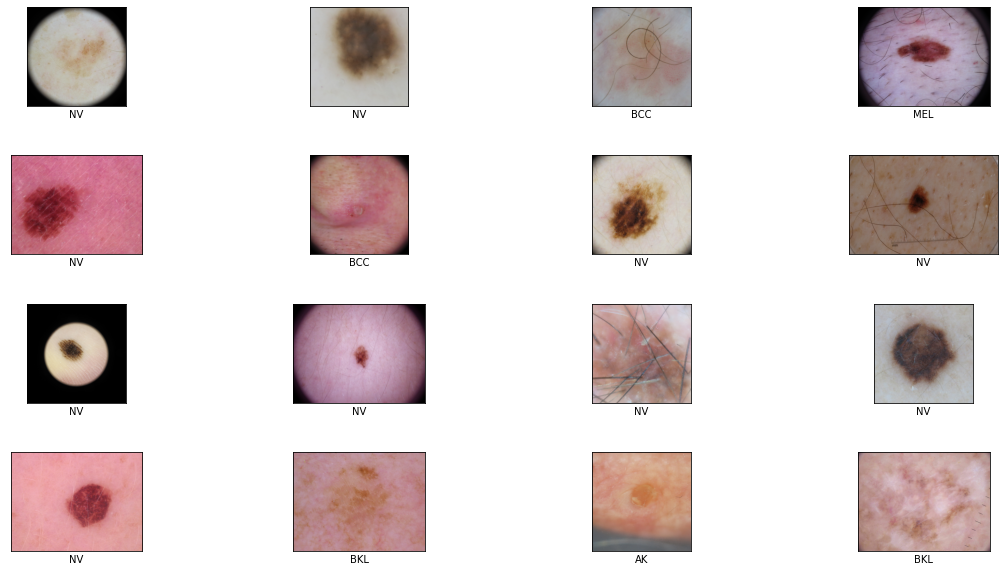

In [4]:
# Show 16 images:
f, ax = plt.subplots(4, 4)
f.subplots_adjust(hspace=0.5, wspace= 0.05)
for i in range(0, 4):
    for j in range(0, 4):
        ax[i, j].imshow(train_data[i * 4 + j][0].transpose(2,0).transpose(0,1).numpy())
        ax[i,j].yaxis.set_visible(False)
        # ax[i,j].xaxis.set_visible(False)
        ax[i,j].set_xlabel(train_data.idx_to_class[train_data[4*i + j][1]])
        ax[i,j].xaxis.set_ticklabels([])
        ax[i,j].xaxis.set_ticklabels([])
        ax[i,j].xaxis.set_ticks([])

In [5]:
# all basic transforms concluded by cropping to (224,224)
img_transforms = nn.Sequential(transforms.RandomRotation(degrees=(0, 180)),transforms.RandomVerticalFlip(),transforms.RandomHorizontalFlip(), transforms.Resize((224, 224)))

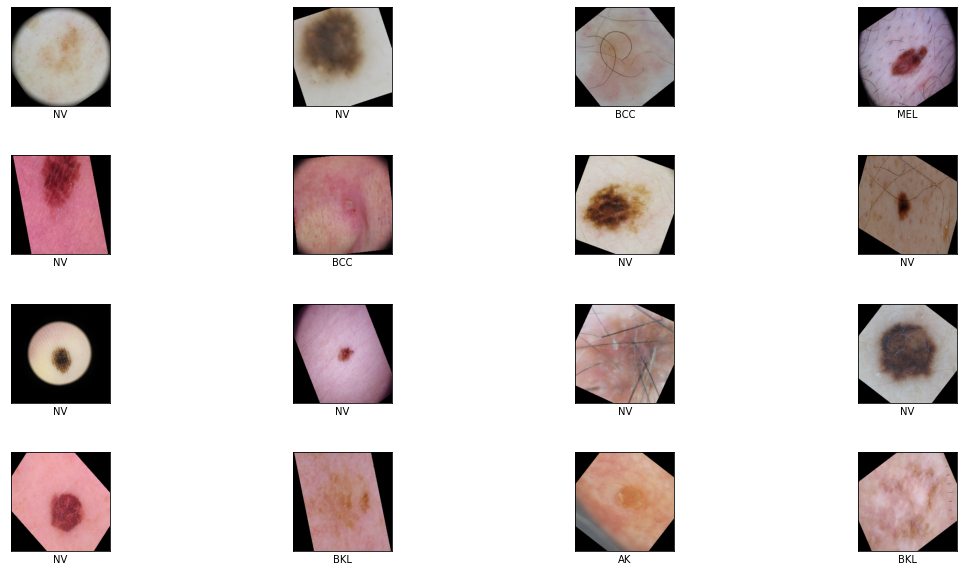

In [6]:
# Effect of using first rotations then cropping to size (224,224)
f, ax = plt.subplots(4, 4)
f.subplots_adjust(hspace=0.5, wspace= 0.05)
for i in range(0, 4):
    for j in range(0, 4):
        image_np = train_data[i * 4 + j][0].numpy()
        trf_img = img_transforms(torch.from_numpy(image_np))
        trf_img = trf_img.numpy()
        trf_img = np.transpose(trf_img,(1,2,0))
        ax[i, j].imshow(trf_img)
        ax[i,j].yaxis.set_visible(False)
        # ax[i,j].xaxis.set_visible(False)
        ax[i,j].set_xlabel(train_data.idx_to_class[train_data[4*i + j][1]])
        ax[i,j].xaxis.set_ticklabels([])
        ax[i,j].xaxis.set_ticklabels([])
        ax[i,j].xaxis.set_ticks([])

In [7]:
# all basic transforms in original sequence
original_transforms = nn.Sequential(transforms.Resize((224, 224)),transforms.RandomRotation(degrees=(0, 180)),transforms.RandomVerticalFlip(),transforms.RandomHorizontalFlip())

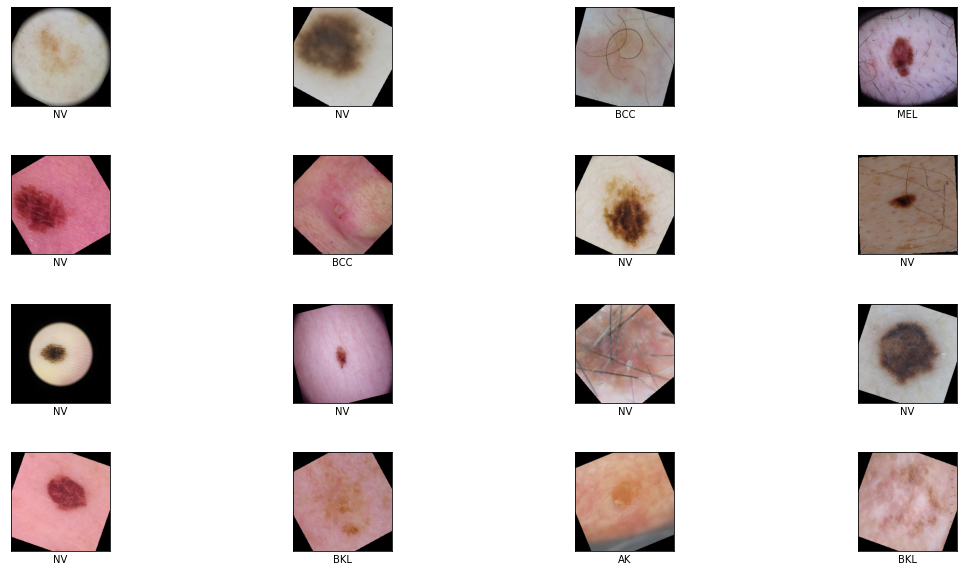

In [8]:
# Effect of using cropping to size (224,224) first then basic transformations
f, ax = plt.subplots(4, 4)
f.subplots_adjust(hspace=0.5, wspace= 0.05)
for i in range(0, 4):
    for j in range(0, 4):
        image_np = train_data[i * 4 + j][0].numpy()
        trf_img = original_transforms(torch.from_numpy(image_np))
        trf_img = trf_img.numpy()
        trf_img = np.transpose(trf_img,(1,2,0))
        ax[i, j].imshow(trf_img)
        ax[i,j].yaxis.set_visible(False)
        # ax[i,j].xaxis.set_visible(False)
        ax[i,j].set_xlabel(train_data.idx_to_class[train_data[4*i + j][1]])
        ax[i,j].xaxis.set_ticklabels([])
        ax[i,j].xaxis.set_ticklabels([])
        ax[i,j].xaxis.set_ticks([])

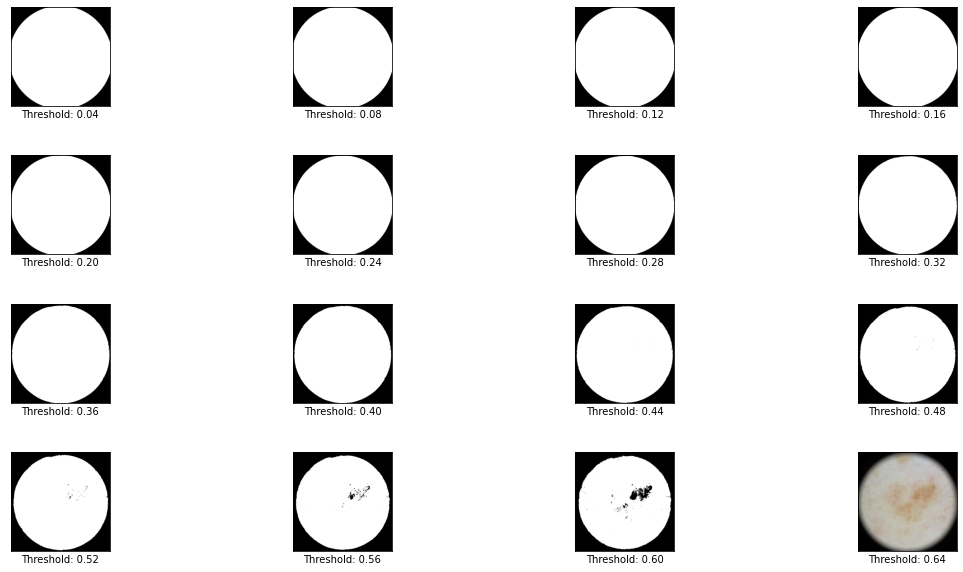

In [9]:

img = None
for k in range(0,100):
    # find first image with a black pixel
    if (train_data[k][0].min() < 0.005):
        img = k
        f, ax = plt.subplots(4, 4)
        f.subplots_adjust(hspace=0.5, wspace= 0.05)
        for i in range(0, 4):
            for j in range(0, 4):
                # convert to black-white image via threshold
                threshold = 0.04 * (i * 4 + j) + 0.04
                grey_img = (torch.sum(train_data[k][0], dim=0) / 3)
                ax[i, j].imshow((1.0 * (grey_img >= threshold)).numpy(), cmap="gray")
                ax[i,j].yaxis.set_visible(False)
                # ax[i,j].xaxis.set_visible(False)
                ax[i,j].set_xlabel(f"Threshold: {threshold:.2f}")
                ax[i,j].xaxis.set_ticklabels([])
                ax[i,j].xaxis.set_ticklabels([])
                ax[i,j].xaxis.set_ticks([])
        break   # Search for the first image with a black border

plt.imshow(train_data[k][0].transpose(0,2).transpose(0,1).numpy(), cmap="gray")

In [10]:
edge = 0.01
images_with_black_edges = []
    

In [11]:
for k in range(3000):
    image = train_data[k][0]
    grey_img = (torch.sum(image, dim=0) / 3).numpy()
    has_black_edges = ((np.average(grey_img[0][:]) < edge) and (np.average(grey_img[-1][:]) < edge) and (np.average(grey_img[:][0]) < edge) and (np.average(grey_img[:][-1]) < edge))
    if(has_black_edges):
        images_with_black_edges.append(image)

In [12]:
original_image = images_with_black_edges[0][0]
grey_img = (torch.sum(images_with_black_edges[0][0], dim=0) / 3).numpy()

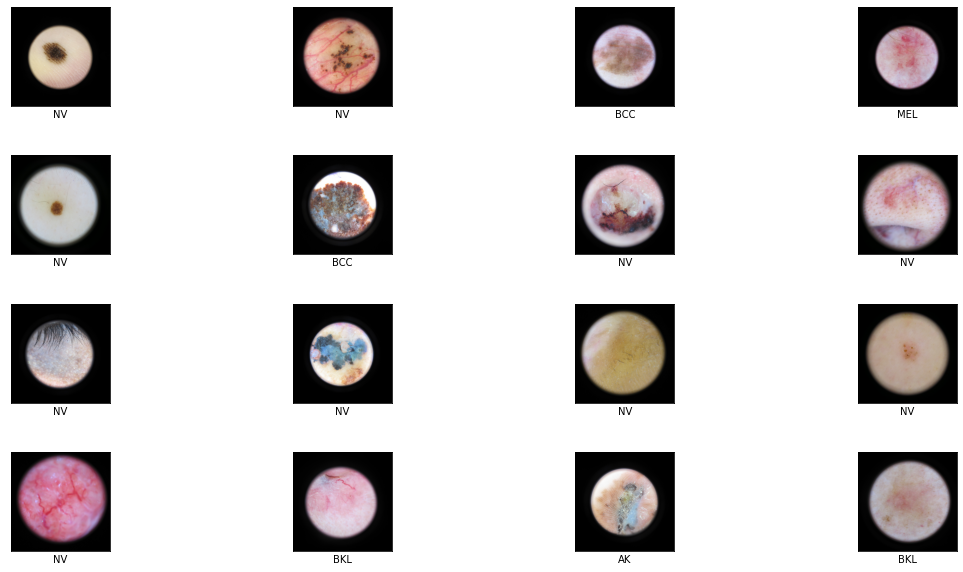

In [13]:
# Testing filtering the images with black edges all around
f, ax = plt.subplots(4, 4)
f.subplots_adjust(hspace=0.5, wspace= 0.05)
for i in range(0, 4):
    for j in range(0, 4):
        image_np = images_with_black_edges[ i* 4 + j]
        trf_img = image_np.numpy()
        trf_img = np.transpose(trf_img,(1,2,0))
        ax[i, j].imshow(trf_img)
        ax[i,j].yaxis.set_visible(False)
        # ax[i,j].xaxis.set_visible(False)
        ax[i,j].set_xlabel(train_data.idx_to_class[train_data[4*i + j][1]])
        ax[i,j].xaxis.set_ticklabels([])
        ax[i,j].xaxis.set_ticklabels([])
        ax[i,j].xaxis.set_ticks([])

In [14]:
def preprocess_images(batch):
    changed_images = []
    for k in range(len(batch.size[0])):
        image = batch[k][0]
        grey_img = (torch.sum(image, dim=0) / 3).numpy()
        has_black_edges = ((np.average(grey_img[0][:]) < edge) and (np.average(grey_img[-1][:]) < edge) and (np.average(grey_img[:][0]) < edge) and (np.average(grey_img[:][-1]) < edge))
        if(has_black_edges):
            blwh_img = (1.0 * (grey_img >= 0.12))
            cov_m = np.cov(blwh_img)
            box_idx = np.argwhere((cov_m) > 0.001)
            outer_points = np.argmax(box_idx, axis=0)
            height= np.abs(box_idx[outer_points[0],0] - box_idx[outer_points[0],1])
            width = np.abs(box_idx[outer_points[1],0] - box_idx[outer_points[1],1])
            image_area = image.size[0]*image.size[1]
            black_area = image_area - (width*height)
            changed_images.append((tv.transforms.functional.resized_crop(image, top=box_idx[0,0], left=box_idx[0,1],height= height, width= width, size=224), dataset[k][1]))
    return black_area,image_area

In [17]:
black_pixels_cut_sum = 0
total_pixels = 0
# Filter out images with black edges
for count, batch in enumerate(original_train_loader):
    print(count, size(batch))
    """
    if train_sample_count is None:
        train_sample_count = np.bincount(batch[1], minlength=len(train_data.classes))
    else:
        train_sample_count += np.bincount(batch[1], minlength=len(train_data.classes))
    black_pixels, image_pixels = preprocess_images(batch)
    black_pixels_cut_sum += black_pixels
    total_pixels += image_pixels
    """
#print(f"Average percentage of black pixels cut: {(black_pixels_cut_sum/total_pixels)*100}% of the image")

RuntimeError: Caught RuntimeError in DataLoader worker process 0.
Original Traceback (most recent call last):
  File "c:\Users\lisap\miniconda3\envs\idp_env\lib\site-packages\torch\utils\data\_utils\worker.py", line 287, in _worker_loop
    data = fetcher.fetch(index)
  File "c:\Users\lisap\miniconda3\envs\idp_env\lib\site-packages\torch\utils\data\_utils\fetch.py", line 52, in fetch
    return self.collate_fn(data)
  File "c:\Users\lisap\miniconda3\envs\idp_env\lib\site-packages\torch\utils\data\_utils\collate.py", line 172, in default_collate
    return [default_collate(samples) for samples in transposed]  # Backwards compatibility.
  File "c:\Users\lisap\miniconda3\envs\idp_env\lib\site-packages\torch\utils\data\_utils\collate.py", line 172, in <listcomp>
    return [default_collate(samples) for samples in transposed]  # Backwards compatibility.
  File "c:\Users\lisap\miniconda3\envs\idp_env\lib\site-packages\torch\utils\data\_utils\collate.py", line 137, in default_collate
    out = elem.new(storage).resize_(len(batch), *list(elem.size()))
RuntimeError: Trying to resize storage that is not resizable


In [16]:
altered_images, black_areas_percentage = preprocess_images(images_with_black_edges)
f, ax = plt.subplots(4, 4)
f.subplots_adjust(hspace=0.5, wspace= 0.05)
for i in range(0, 4):
    for j in range(0, 4):
        image_np = altered_images[ i* 4 + j][0]
        trf_img = image_np.numpy()
        #print(trf_img.shape)
        trf_img = np.transpose(trf_img,(1,2,0))
        ax[i, j].imshow(trf_img)
        ax[i,j].yaxis.set_visible(False)
        # ax[i,j].xaxis.set_visible(False)
        ax[i,j].set_xlabel(train_data.idx_to_class[train_data[4*i + j][1]])
        ax[i,j].xaxis.set_ticklabels([])
        ax[i,j].xaxis.set_ticklabels([])
        ax[i,j].xaxis.set_ticks([])

AttributeError: 'list' object has no attribute 'size'

(1024, 1024)
torch.Size([3, 1024, 1024])
torch.Size([3, 224, 224])


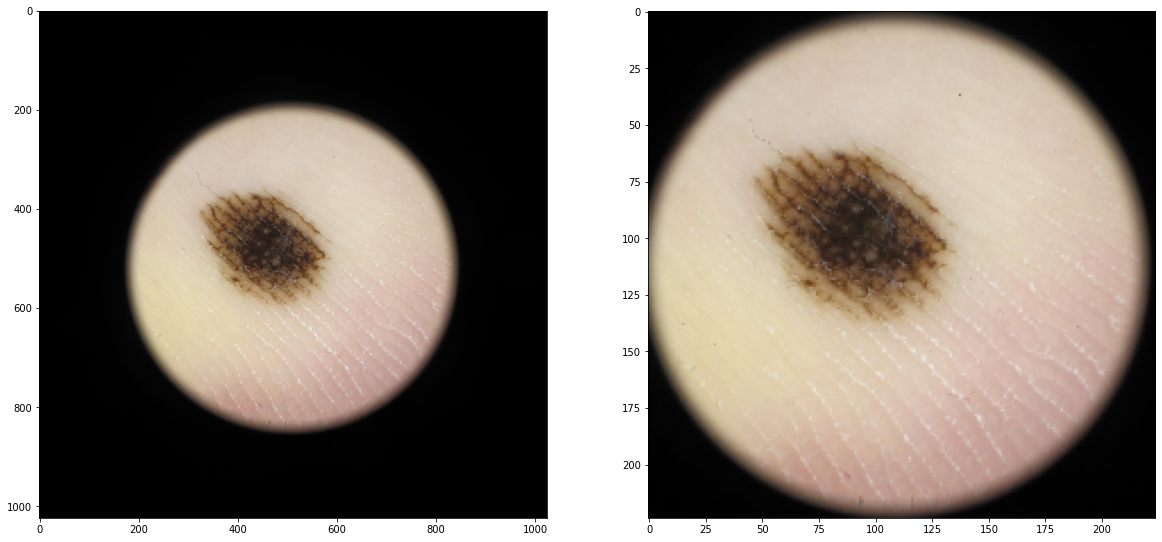

In [ ]:
blwh_img = (1.0 * (grey_img >= 0.12))
cov_m = np.cov(blwh_img)
eig_values, eig_vectors = np.linalg.eig(cov_m)
test = ((cov_m) > 0.001)
coor = np.unravel_index(np.argmax(test),test.shape)
box_idx = np.argwhere(test>0)
outer_points = np.argmax(box_idx, axis=0)
height= np.abs(box_idx[outer_points[0],0] - box_idx[outer_points[0],1])
width = np.abs(box_idx[outer_points[1],0] - box_idx[outer_points[1],1])
print(grey_img.shape)
print(original_image.shape)
cropped_img = tv.transforms.functional.resized_crop(original_image, top=box_idx[0,0], left=box_idx[0,1], 
                                                            height= height, 
                                                            width= width, size=224)
f, ax = plt.subplots(1, 2)
print(cropped_img.shape)
ax[0].imshow(np.transpose(original_image,(1,2,0)))
ax[1].imshow(np.transpose(cropped_img,(1,2,0)))

In [ ]:
def compute_weights(dataset, weight_scheme = 0):
    class_sample_count = np.unique(dataset.targets, return_counts=True)[1]
    weights = 1.0 / class_sample_count
    # no weight scheme used
    if(weight_scheme == 0):
        return None, None
    elif(weight_scheme == 2):
        weights_avg = np.avg(weights)
        weights = weights + weights_avg
        # Medically especially important classes BCC:1, MEL:4, NV:5 and SCC:6 recieve higher weights
    elif(weight_scheme == 3):
        weights = np.array([1,4,1,1,4,2,4,1])
    weights_per_sample = np.array([weights[t] for t in dataset.targets])
    return torch.from_numpy(weights).float(), torch.from_numpy(weights_per_sample).float()

Original weights: (amplified for better comparison)
[0.11534025 0.03009329 0.03810975 0.41841003 0.02211411 0.00776699
 0.15923567 0.39525694]
Weights changed relatively to imbalance
[0.26363114 0.17838417 0.18640064 0.56670094 0.17040499 0.15605786
 0.30752656 0.5435478 ]
